# Title: Cannabis Retail Sales 
# Authors: Tae Sakong
***
## Problem Statement
- What is the domain?
    - Brief history of cannabis industry in America
    - Overview of cannabis market features
    - Gap in knowledge
- Existing data and models
    - cannabis retail data
    - cannabis retail sales models or equivalents
    - What is the purpose of modeling this data?
- Goal
    - What is the goal of this project
        - Evaluate the dynamics of cannabis retail sales, and if they vary between Adult-Use vs Medical Marijuana products
    - How will you achieve this goal?
        - Build a time-series machine learning model that forecasts cannabis retail sales
    - Future Goals
        - Build database of cannabis retail sales by product type
        - Integrate database into machine learning model
        - Deploy and implement machine learning model into inventory tracking system
***
## Objectives
1. Process the data
2. Explore the data
3. Develop a Model
4. Train and Fit the model
5. Make predictions by using the model
6. Evaluate the model
7. What are the next steps?
***
## Data Processing
1. Import the data
2. Clean and process the data
***
## Exploratory Data Analysis:
1. Visualize distribution of variables
***
## Data Analysis
1. Test Assumptions
    - Normal Distribution
    - Homegeneity of Variance
2. Statistical tests
    - Rationale
        - Evidence from literature, EDA, etc.
    -Hypothesis:
        - Direction and magnitude?
***
## Model Development
1. Machine learning model
    - Algorithm
        - Rationale
2. Train the Model
3. Test the Model
4. Evaluate the Model
***
## Results

***
## Summary

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline

## Data Processing:

Data Source: __(https://data.ct.gov/Health-and-Human-Services/Cannabis-Retail-Sales-by-Week-Ending/ucaf-96h6)__

Summary of Data:
- What is the data about?
- When was the data collected?
- What is the source of the data?
- Who authored the data?
- Cite the source

### 1. Import the data

In [2]:
# URL for dat
url = "https://data.ct.gov/api/views/ucaf-96h6/rows.csv?accessType=DOWNLOAD"

# Convert csv to dataframe
df = pd.read_csv(url)

In [3]:
# Inspect the dataframe
df.head()

,Week Ending,Adult-Use Retail Sales,Medical Marijuana Retail Sales,Total Adult-Use and Medical Sales,Adult-Use Products Sold,Medical Products Sold,Total Products Sold,Adult-Use Average Product Price,Medical Average Product Price
0,01/14/2023,1485019.32,1776700.69,3261720.01,33610,49312,82922,44.25,36.23
1,01/21/2023,1487815.81,2702525.61,4190341.42,33005,77461,110466,45.08,34.89
2,01/28/2023,1553216.30,2726237.56,4279453.86,34854,76450,111304,44.56,35.65
3,01/31/2023,578840.62,863287.86,1442128.48,12990,24023,37013,44.56,35.93
4,02/04/2023,1047436.20,1971731.40,3019167.60,24134,56666,80800,43.49,34.84


In [4]:
# Check datatypes and variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week Ending                        41 non-null     object 
 1   Adult-Use Retail Sales             41 non-null     float64
 2   Medical Marijuana Retail Sales     41 non-null     float64
 3   Total Adult-Use and Medical Sales  41 non-null     float64
 4   Adult-Use Products Sold            41 non-null     int64  
 5   Medical Products Sold              41 non-null     int64  
 6   Total Products Sold                41 non-null     int64  
 7   Adult-Use Average Product Price    41 non-null     float64
 8   Medical Average Product Price      41 non-null     float64
dtypes: float64(5), int64(3), object(1)
memory usage: 3.0+ KB


In [5]:
# Check for missing values
df.isnull().sum()

Week Ending                          0
Adult-Use Retail Sales               0
Medical Marijuana Retail Sales       0
Total Adult-Use and Medical Sales    0
Adult-Use Products Sold              0
Medical Products Sold                0
Total Products Sold                  0
Adult-Use Average Product Price      0
Medical Average Product Price        0
dtype: int64

This dataset contains 9 variables, each with 41 observations.

| Variable Name | Description | Type      |
|:--------------|:------------|:----------|
|Week Ending |Dates by week |Object |
|Adult-Use Retail Sales | Adult-Use Cannabis Retail Sales |float64 |
|Medical Marijuana Retail Sales | Medical Marijuana Retail Sales |float64 |
|Total Adult-Use and Medical Sales | Total Retail Sales for Adult-Use Cannabis and Medical Marijuna Marijuana |float64 |
|Adult-Use Products Sold | Number of products sold in adult-use cannabis market |int |
|Medical Products Sold | Number of medical marijuana products sold |int |
|Total Products Sold | Number of adult-use cannabis and medical products sold |int |
|Adult-Use Average Product Price | Average price of adult-use products |float 64 |
|Medical Average Product Price | Average price of medical marijuana products |float64 |


The data can be organized into the following:

1. The intervals for all reported values are determined by "Week Ending." Where, the "Week Ending" represents the time intervals at which sales data were collected.

2. Product types are categorized into "Adult-Use" or "Medical Marajuana." Such that, the number of sales, in terms of quantities or dollar amounts, are reported for each category. Additionally, there are measures that Total the sales, in terms of quantities or dollar amounts, for both categories of product types.

3. Given the product quantities and dollar amounts sold, the data also contains the average product prices at each time interval.

In summary, this dataset contains a time-series of cannabis product sales, further segmented by their product type; Retail Marajuana vs Medical Marajuana.

### 2. Clean and Process Data

In general, most of the datatypes are correct.

Float64 represents the variables that represent the dollar amounts of products sold:
- Adult-Use Retail Sales
- Medical Marijuana Retail Sales
- Total Adult-Use and Medical Sales
- Adult-Use Average Product Price
- Medical Average Product Price

Int64 represents the variables that represent the number of products sold:
- Adult-Use Products Sold
- Medical Products Sold 
- Total Products Sold

However, **Week Ending** will need to be converted to datetime. The rationale being: this variable represents the time intervals at which, presumably sales data was collected. Therefore, for ease of future statitiscal operations, **Week Ending** will be converted to the type, DateTime.

Regarding missing values, there are none. So, no methods will be required to process or modify missing data.

In [6]:
# Convert Week Ending to Datetime
df['Week Ending'] = pd.to_datetime(df['Week Ending'])

In [7]:
# Check datatypes after type conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Week Ending                        41 non-null     datetime64[ns]
 1   Adult-Use Retail Sales             41 non-null     float64       
 2   Medical Marijuana Retail Sales     41 non-null     float64       
 3   Total Adult-Use and Medical Sales  41 non-null     float64       
 4   Adult-Use Products Sold            41 non-null     int64         
 5   Medical Products Sold              41 non-null     int64         
 6   Total Products Sold                41 non-null     int64         
 7   Adult-Use Average Product Price    41 non-null     float64       
 8   Medical Average Product Price      41 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 3.0 KB


## Exploratory Data analysis

- Look at the distributions
- Look at the relationships
- Look at the correlations

Plot the Total Sales

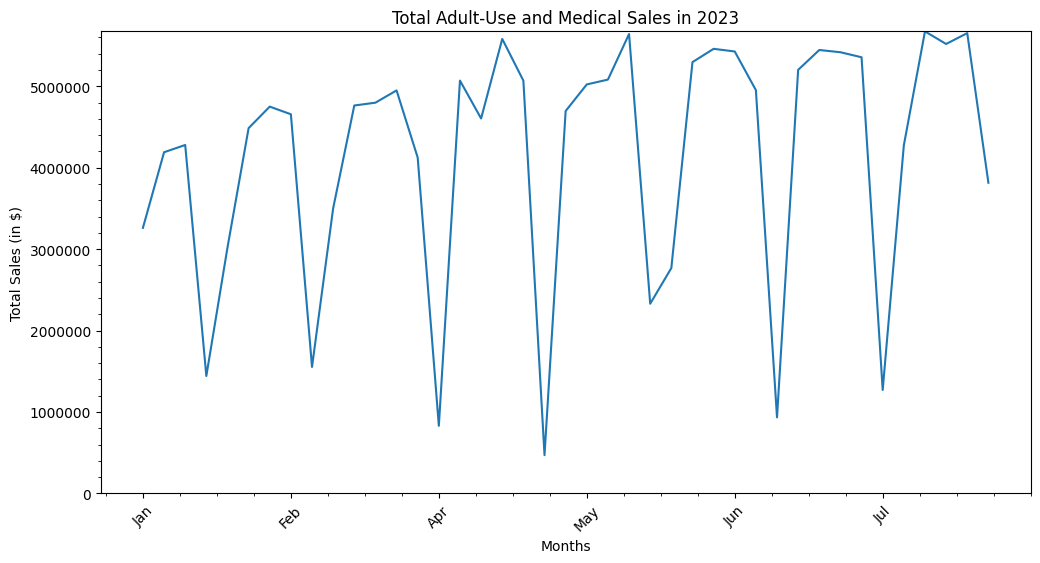

In [37]:
# Create the figure
plt.figure(figsize=(12,6))

# Plot the datae
plt.plot(
    df.index,
    df['Total Adult-Use and Medical Sales']
)

# Set x-axis major ticks as month names
plt.xticks(df.index[::7], df['Week Ending'].dt.strftime('%b')[::7])

# Set x-axis as minor ticks as "Month-Day" values
plt.minorticks_on()

# Label the plot
plt.title('Total Adult-Use and Medical Sales in 2023')
plt.xlabel('Months')
plt.ylabel('Total Sales (in $)')

# Adjust the y-axis labels
plt.ylim(0, max(df['Total Adult-Use and Medical Sales']))
plt.ticklabel_format(style='plain',axis='y')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


Best way to compare sales by product type?

Plot the Total Products Sold

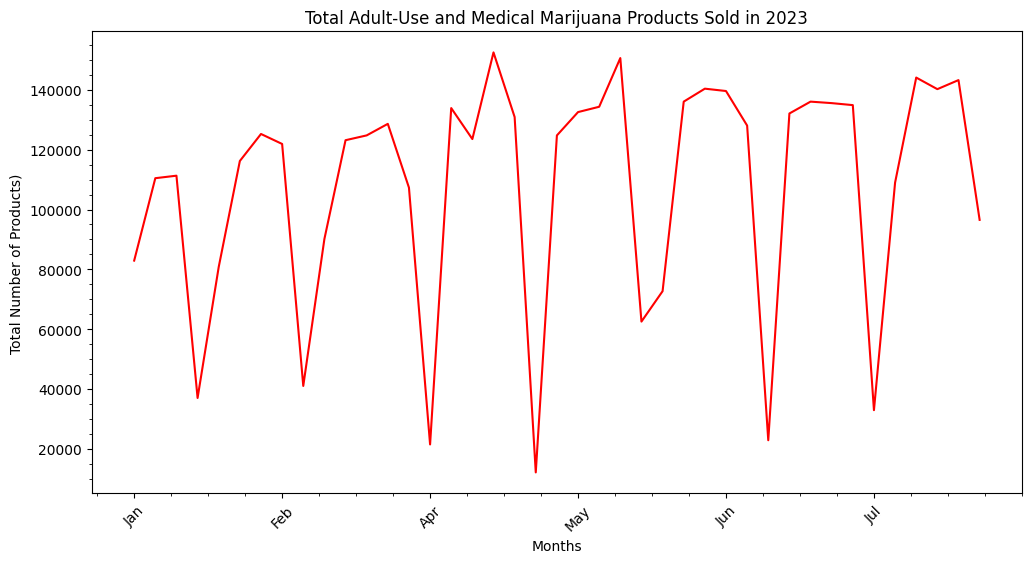

In [38]:
# Create the figure
plt.figure(figsize=(12,6))

# Plot the datae
plt.plot(
    df.index,
    df['Total Products Sold'],
    color ='red'
)

# Set x-axis major ticks as month names
plt.xticks(df.index[::7], df['Week Ending'].dt.strftime('%b')[::7])

# Set x-axis as minor ticks as "Month-Day" values
plt.minorticks_on()

# Label the plot
plt.title('Total Adult-Use and Medical Marijuana Products Sold in 2023')
plt.xlabel('Months')
plt.ylabel('Total Number of Products)')

# Adjust the y-axis label

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


Best way to show total number of products sold by product type?